<a href="https://colab.research.google.com/github/Mostafa-MMK/VaRBacktestingEngine/blob/main/0_historical_var_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [24]:
# Installing Packages
!pip install yfinance scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# Main Functions (OOP)

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [26]:
class RiskEngine:
    def __init__(self, tickers, df_returns = None):
        self.tickers = tickers
        self.df_returns = df_returns

    # Getting and Wrangling Data
    def data_preparation(self):
        data = yf.download(self.tickers, start= '2000-01-01', auto_adjust=True)['Close'].dropna()
        data.columns = self.tickers
        df_returns = np.log(data/data.shift(1)).dropna()
        self.df_returns = df_returns
        return df_returns


    # Variance Covariance Method
    def VC_VaR_ES(self):

        confidences = np.arange(0.90, 1.0, 0.01)
        mu = self.df_returns.mean()
        sigma = self.df_returns.std()
        np.random.seed(121)

        vc_results = []
        for conf in confidences:
            z = norm.ppf(conf)
            phi_z = norm.pdf(z)
            for tick in self.tickers:
                vars_ = mu[tick] - (sigma[tick] * z)
                exp_terms = (np.exp(-0.50 * z ** 2)) / ((1 - conf) * np.sqrt(2 * np.pi))
                es_ = mu[tick] - (sigma[tick] * exp_terms)
                vc_results.append({'Confidence':conf,  'Ticker':tick, 'Method':'VC', 'VaR':vars_, 'ES':es_})
        vc_results = pd.DataFrame(vc_results)
        vc_results.set_index('Confidence', inplace = True)
        return vc_results

    # Historical Simulated VaR and ES
    def Hist_VaR_ES(self):
        confidences = np.arange(0.90, 1.0, 0.01)
        sorted_returns = self.df_returns.apply(np.sort)
        hist_results = []

        for conf in confidences:
            for tick in self.tickers:
                vars_ = np.quantile(sorted_returns[tick], (1 - conf))
                es_ = sorted_returns[tick][sorted_returns[tick] <= vars_].mean()
                hist_results.append({'Confidence': conf, 'Ticker': tick, 'Method':'HS', 'VaR': vars_, 'ES': es_})
        hist_results = pd.DataFrame(hist_results)
        hist_results.set_index('Confidence', inplace = True)
        return hist_results

    # Bootstrapped Simulated VaR and ES
    def BootStrapped_HS_VaR_ES(self):
        rng = np.random.default_rng(100)
        confidences = np.arange(0.90, 1.0, 0.01)
        num_simulation = 10000
        simulated_returns = rng.choice(self.df_returns.values, size = num_simulation, replace = True)
        sorted_returns = (pd.DataFrame(simulated_returns, columns = self.df_returns.columns)).apply(np.sort)

        boot_results = []
        for conf in confidences:
            for tick in self.tickers:
                vars_ = np.quantile(sorted_returns[tick], (1 - conf))
                es_ = sorted_returns[tick][sorted_returns[tick]<= vars_].mean()
                boot_results.append({'Confidence': conf, 'Ticker':tick, 'Method': 'BTS', 'VaR':vars_, 'ES':es_})

        boot_results = pd.DataFrame(boot_results)
        boot_results.set_index('Confidence', inplace = True)
        return boot_results

    # Monte-Carlo Simulated VaR and ES
    def Monte_Carlo_VaR_ES(self):
        rng = np.random.default_rng(10)
        num_simulation = 10000
        confidences = np.arange(0.90, 1.0, 0.01)

        mu = self.df_returns.mean()
        sigma = self.df_returns.std()

        sample_returns = rng.normal(loc = mu, scale = sigma, size = (num_simulation, len(self.df_returns.columns)))
        sorted_returns = (pd.DataFrame(sample_returns, columns = self.df_returns.columns)).apply(np.sort)
        mc_results = []

        for conf in confidences:
            for tick in self.tickers:
                vars_ = np.quantile(sorted_returns[tick], (1 - conf))
                es_ = sorted_returns[tick][sorted_returns[tick] <= vars_].mean()
                mc_results.append({'Confidence': conf, 'Ticker': tick, 'Method': 'MC', 'VaR': vars_, 'ES': es_})
        mc_results = pd.DataFrame(mc_results)
        mc_results.set_index('Confidence', inplace = True)
        return mc_results

# Executions

In [27]:
# Results
tickers = ['AAPL', 'TSLA', 'GOOG', 'MSFT']
framework = RiskEngine(tickers)
df_returns = framework.data_preparation()
vc_results = framework.VC_VaR_ES()
hist_results = framework.Hist_VaR_ES()
boot_results = framework.BootStrapped_HS_VaR_ES()
mc_results = framework.Monte_Carlo_VaR_ES()

[*********************100%***********************]  4 of 4 completed


# Plotting Results

## Variance Covariance Method

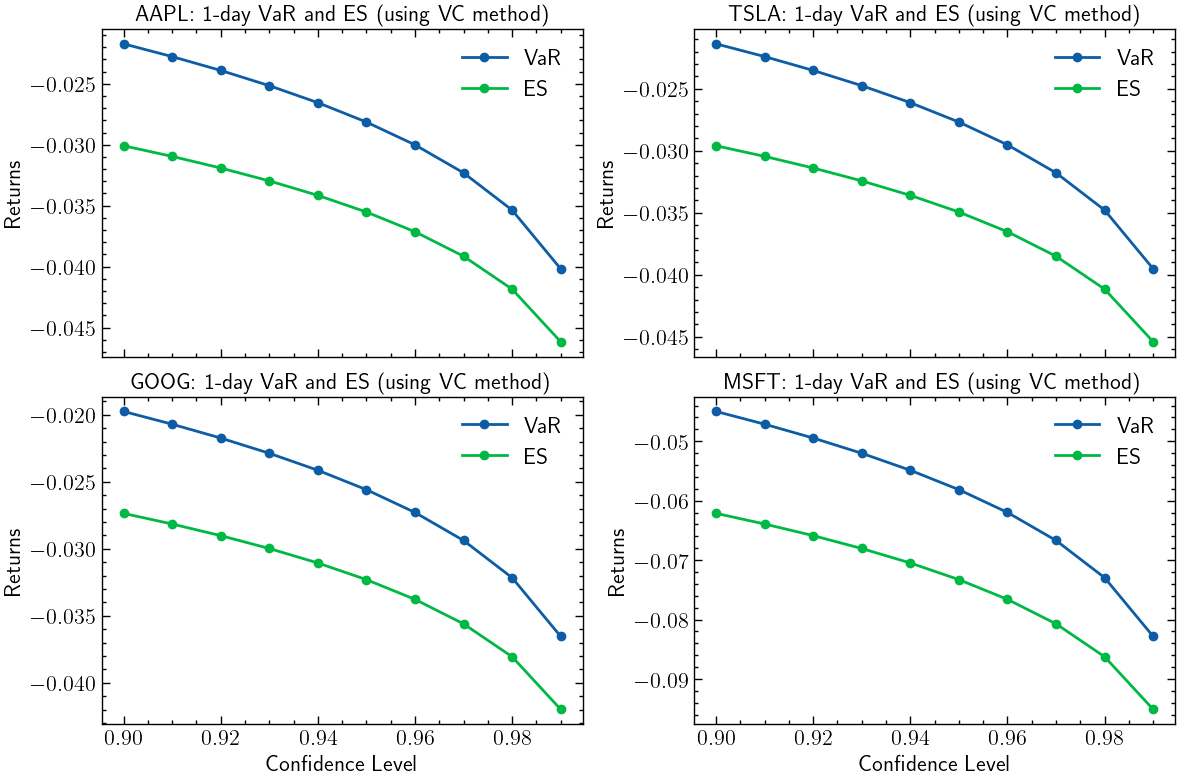

In [28]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  vc_results[vc_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using VC method)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)

plt.tight_layout()
plt.show()

## Historical Simulated Method

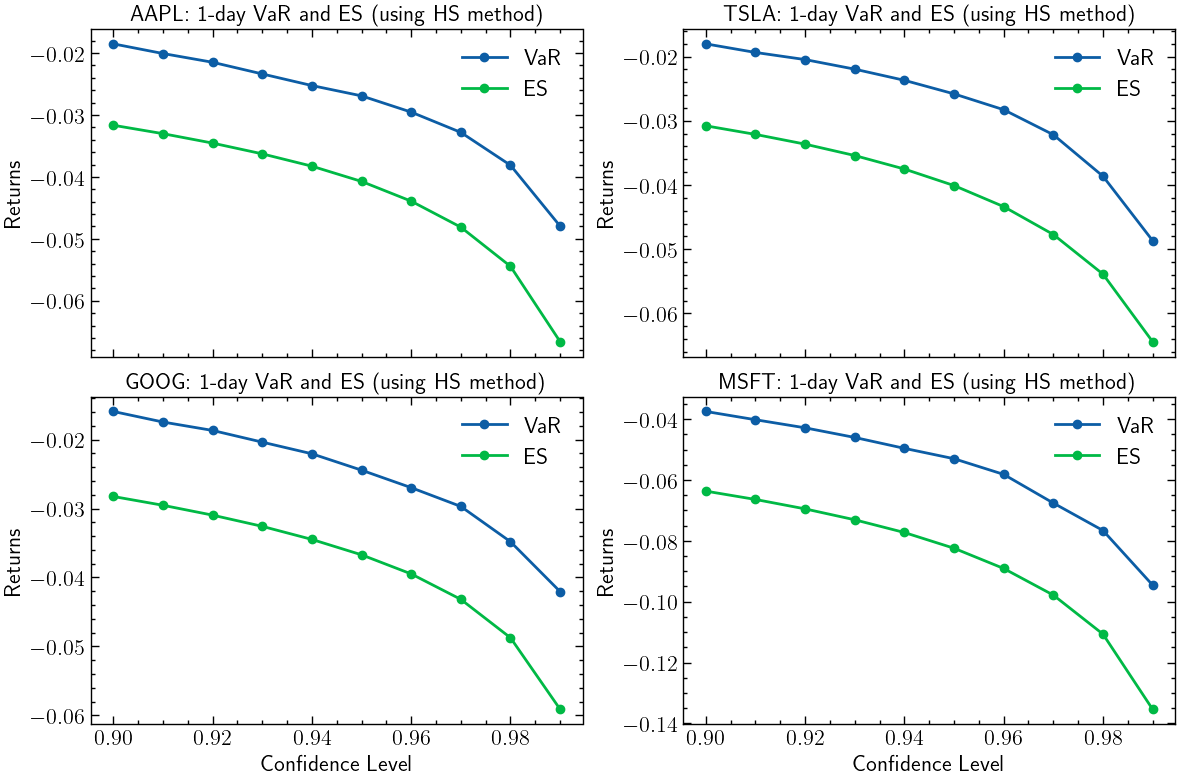

In [29]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  hist_results[hist_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using HS method)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()

## Bootstrapping Simulated Method

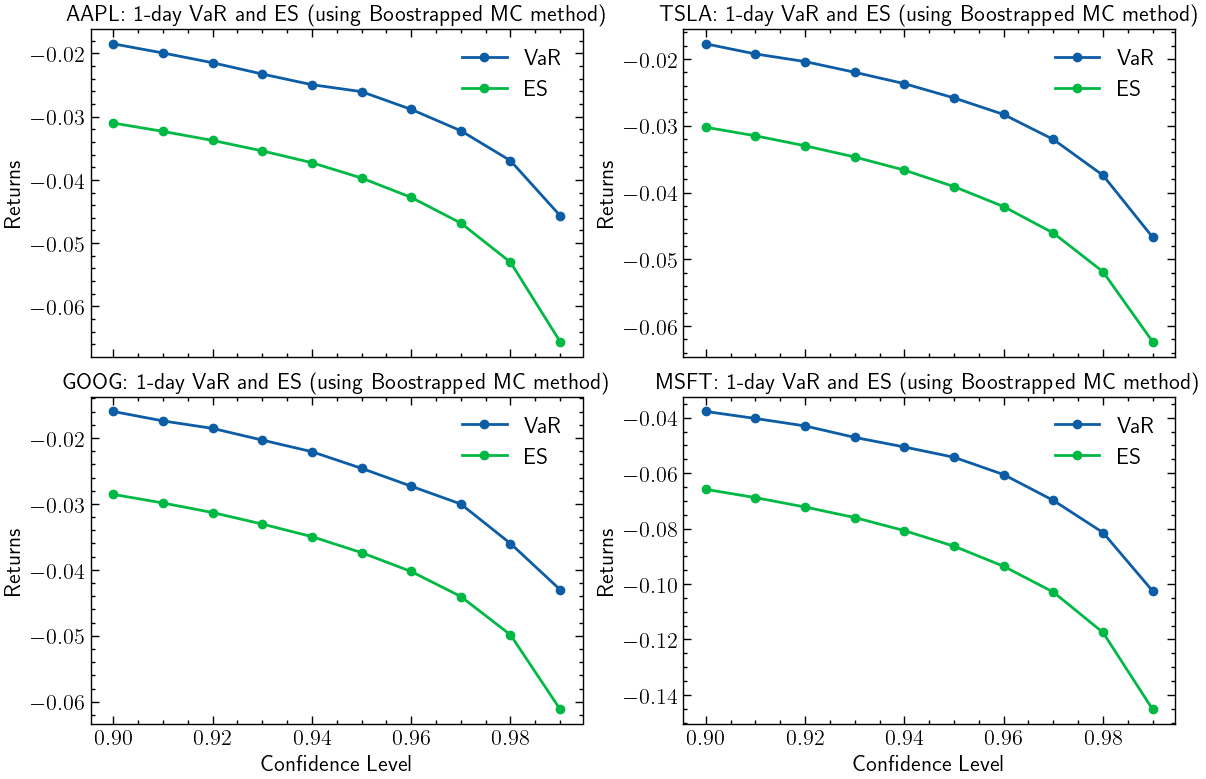

In [30]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  boot_results[boot_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using Boostrapped MC method)")
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()

## Monte Carlo Simulation Method

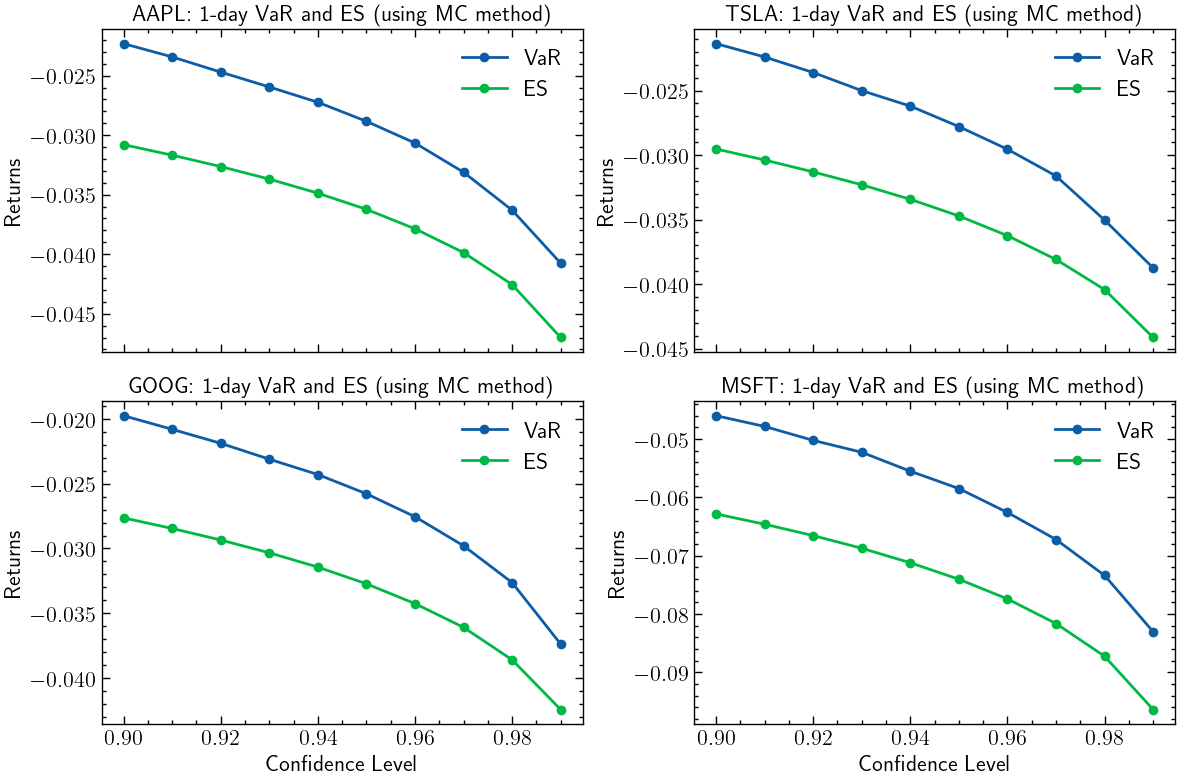

In [31]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  mc_results[mc_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using MC method)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()